<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание проекта" data-toc-modified-id="Описание проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Описание проекта

## Отток клиентов

Из некоторого банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. По заданию заказчика метрику нужно будет довести до 0.59. Проверять *F1*-меру будем на тестовой выборке.

Дополнительно заказчик попросил измерить *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

## План работы

В данном проекте необходимо будет сделать:  
- загрузить данные  
- обработать пропуски
- определить фичи и закодировать категориальные
- при необходимости провести масштабирование
- определить модель и гиперпараметры
- на выбранной модели проверить дисбаланс классов
- проверить получившиеся метрики

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

# Подготовка данных

Признаки

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

Целевой признак

    Exited — факт ухода клиента

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('D:\Подготовка DS Яндекс.Практикум\Churn.csv', index_col='RowNumber')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


В столбце Tenure наблюдаются пропуски. Зависимость от остальных признаков для данного признака найти проблематично (если вообще она имеется). Заменю на медиану.

In [3]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median()).astype('int')
data

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


Посмотрим на зависимости признаков

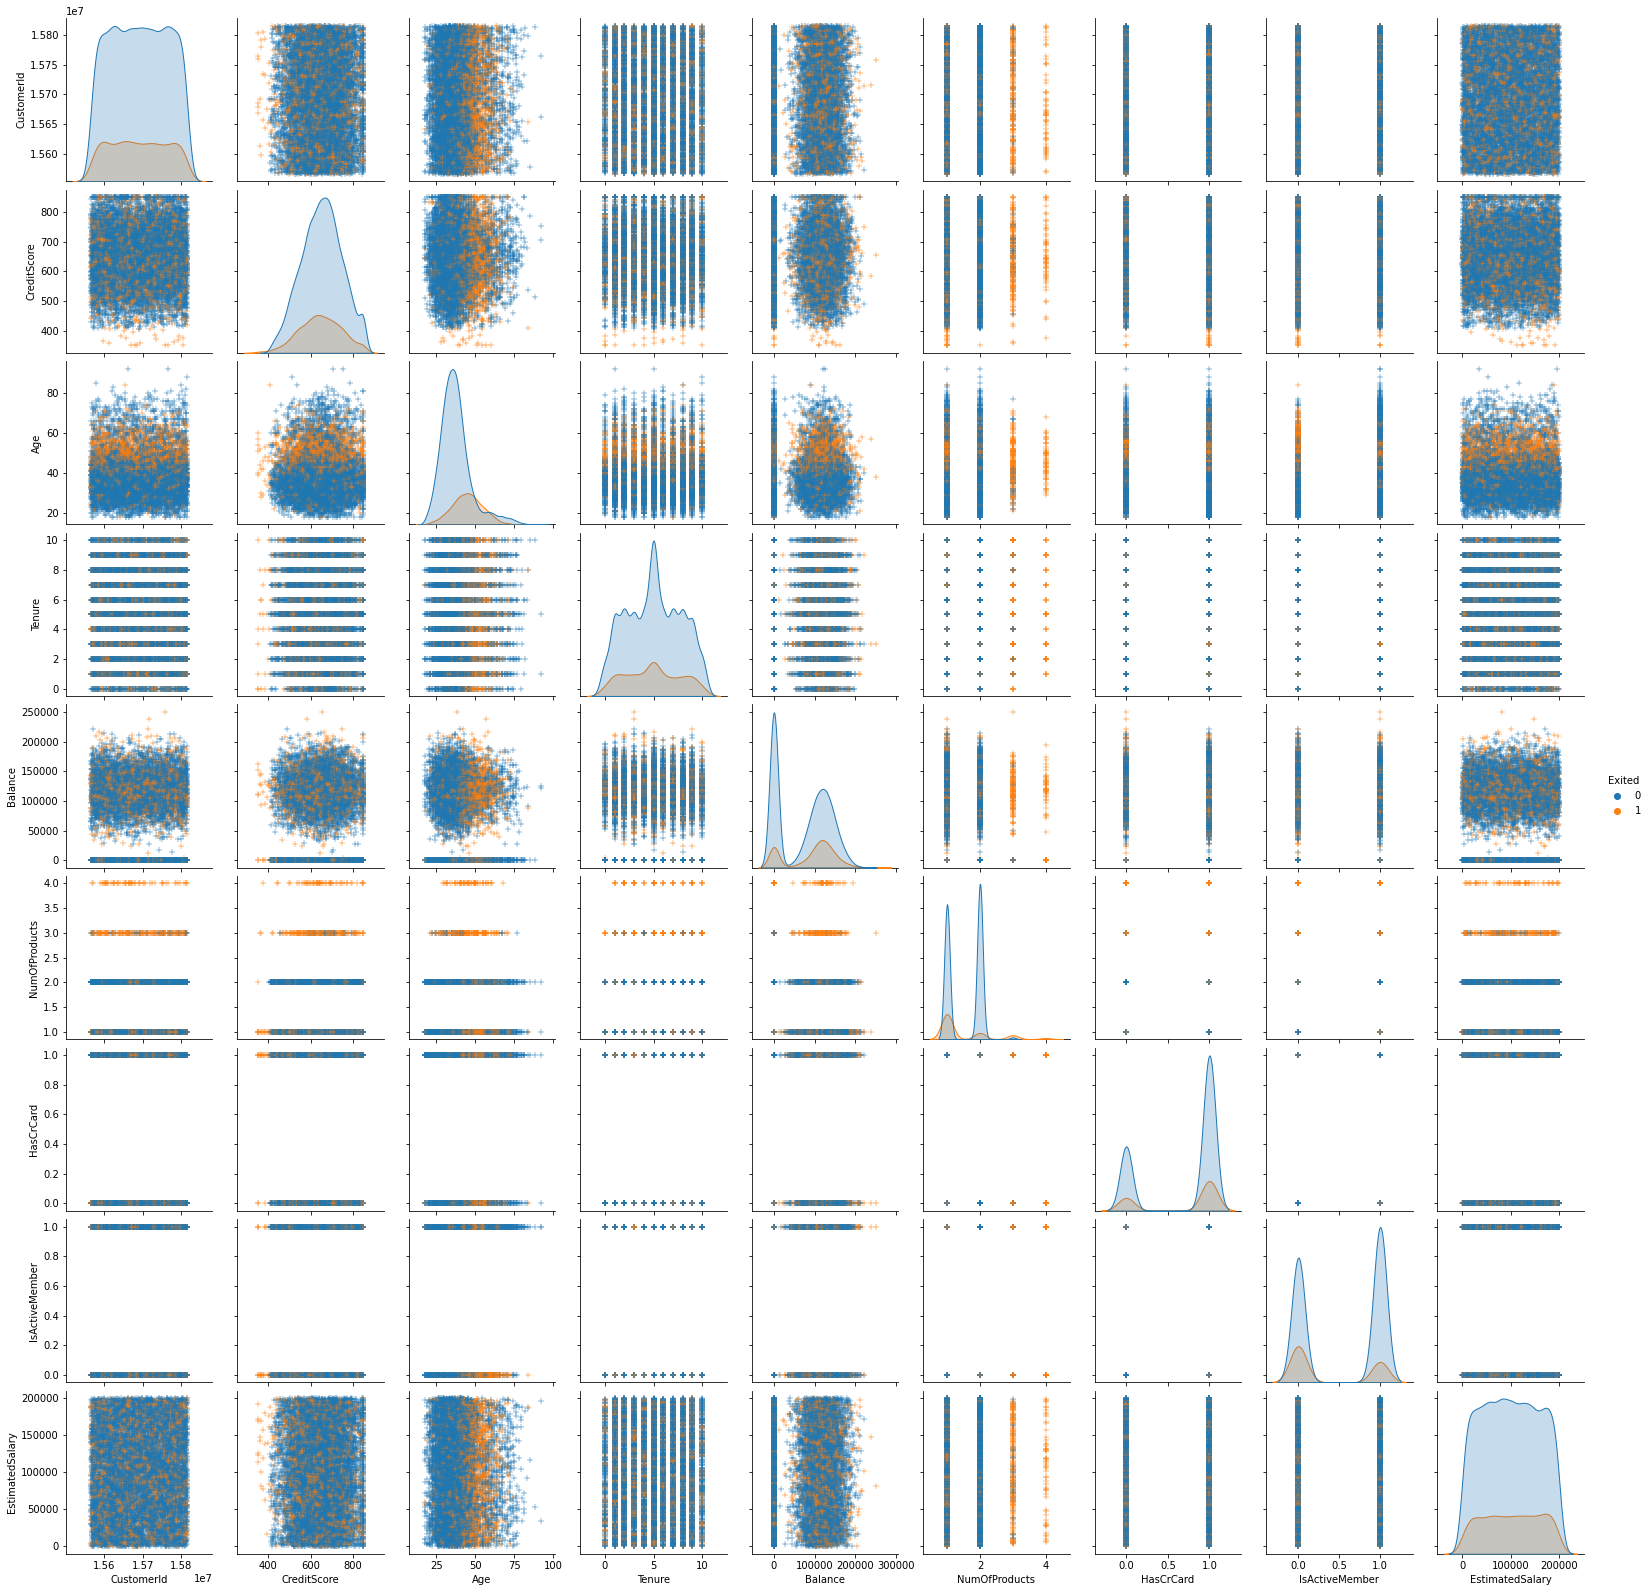

In [4]:
sns.pairplot(data, hue='Exited', markers='+')

Признаки с фамилией клиента и его ID врядли каким то образом влияют на решение клиента об уходе

In [5]:
data = data.drop(['CustomerId', 'Surname'], axis=1)
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,709,France,Female,36,7,0.00,1,0,1,42085.58,1


Далее займусь прямым кодированием категориальных признаков и масштабированием получившихся данных.

In [6]:
data_ohe = pd.get_dummies(data, drop_first=True)

target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

features_train, features_v_t, target_train, target_v_t = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_v_t, target_v_t, test_size=0.5, random_state=12345, stratify=target_v_t)

In [7]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)
(6000,)
(2000,)
(2000,)


Количественные признаки подлежащие масштабированию расположены в столбцах CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary.

In [8]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [9]:
pd.options.mode.chained_assignment = None

In [10]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [11]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

# Исследование задачи

Попробуем в первую очередь LogisticRegression:

In [48]:
model = LogisticRegression(class_weight='balanced', random_state=12345).fit(features_train, target_train)

In [54]:
predicted_valid = model.predict(features_valid)

In [53]:
print(f1_score(target_valid, predicted_valid))

0.5285338015803336


Чтож, ЛогРег показал результат превышающий искомый в 0.48, но надо еще проверить остальные модели.

Теперь разберемся с деревянными моделями. Сначала посмотрим на случайный лес. Попробуем подобрать гиперпараметры с помощью grid search.

In [12]:
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,10, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

In [13]:
model = RandomForestClassifier(random_state=12345)

In [14]:
grid = GridSearchCV(model, parametrs, cv=5, n_jobs=-1)
grid.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 10, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [15]:
grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 40}

Итак, таким образом выявили лучшие гиперпараметры для данной модели. Посмотрим матрицы ошибок и показатель f1 на валидационной выборке.

In [16]:
model = RandomForestClassifier(max_depth=9,
                               min_samples_leaf=2,
                               min_samples_split=6,
                               n_estimators=40)
model.fit(features_train, target_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=40)

In [17]:
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))
print(f1_score(target_valid, predicted_valid))

[[1543   49]
 [ 220  188]]
0.5829457364341084


F1-мера равна 0,58. Чтоже, для улучшения модели стоит побороться с дисбалансом. Но сначала посмотрим на подбор гиперпараметров другим способом.

In [18]:
grid = RandomizedSearchCV(model, parametrs, n_iter=100, cv=5, n_jobs=-1).fit(features_train, target_train)
grid.best_params_

{'n_estimators': 40,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_depth': 9}

In [19]:
model = RandomForestClassifier(max_depth=9,
                               min_samples_leaf=2,
                               min_samples_split=4,
                               n_estimators=40,
                               random_state=12345).fit(features_train, target_train)

In [20]:
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))
print(f1_score(target_valid, predicted_valid))

[[1542   50]
 [ 218  190]]
0.5864197530864197


Посмотрим теперь на простую деревянную модель, а именно дерево решений.

In [21]:
parametrs = { 'max_depth': range (1,10, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

In [22]:
model = DecisionTreeClassifier(random_state=12345)

Для сокращения затрат времени посмотрим параметры с помощю случайного подбора.

In [23]:
grid = RandomizedSearchCV(model, parametrs, n_iter=100, cv=5, n_jobs=-1).fit(features_train, target_train)
grid.best_params_

{'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 5}

In [24]:
model = DecisionTreeClassifier(max_depth=5,
                               min_samples_split = 6,
                               min_samples_leaf = 1,
                               random_state=12345).fit(features_train, target_train)

In [25]:
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))
print(f1_score(target_valid, predicted_valid))

[[1544   48]
 [ 237  171]]
0.5454545454545455


| Модель    | Значение метрики
:-------- |:-----:
LogisticRegression  | 0.52  
RandomForestClassifier      | 0.59    
DecisionTreeClassifier      | 0.54     

Показатели лучше у случайного леса. Его и оставим и перейдем к борьбе дисбалансом.

In [55]:
model = RandomForestClassifier(max_depth=9,
                               min_samples_leaf=2,
                               min_samples_split=4,
                               n_estimators=40,
                               random_state=12345).fit(features_train, target_train)

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

# Борьба с дисбалансом

Для начала изучим текущий баланс.

In [56]:
model.predict_proba(features_valid)

array([[0.67936041, 0.32063959],
       [0.76823555, 0.23176445],
       [0.86389632, 0.13610368],
       ...,
       [0.91750162, 0.08249838],
       [0.92019174, 0.07980826],
       [0.91893007, 0.08106993]])

Попробуем справиться с дисбалансом одни из двух способов: upsmaple и downsample. Сначала обьявим функцию для апсэмплинга.

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled)
    
    return features_upsampled, target_upsampled

In [29]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [30]:
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6432374866879659


Проверим не улучшится ли метрика, если провести даунсэмплинг.

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [32]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [33]:
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6066985645933014


Апсэмплинг показал себя лучше. Для прогонки на тестовой выборке еще раз обучим модель с лучшими гиперпараметрами и с использованием апсэмплинга.

In [34]:
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

# Тестирование модели

Собственно, прогоним нашу готовую модель на тестовой выборке.

In [35]:
print("ROC_AUC-обучающая:", roc_auc_score(target_train, model.predict_proba(features_train)[:,1]))
print("ROC_AUC-валидная:", roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1]))
print("ROC_AUC-тест:", roc_auc_score(target_test, model.predict_proba(features_test)[:,1]))

ROC_AUC-обучающая: 0.949521607147873
ROC_AUC-валидная: 0.8687586215390679
ROC_AUC-тест: 0.8536147858181757


Насколько мы помним, эта метрика показывает отношение ложно-положительных предсказаний, к истинно-положительным. Чем ближе метрика к 1 тем лучше. В нашем случае метрика равняется 0.85, что является неплохим результатом, говорящим о том, что из всех положительных предсказаний 85% будут достоверными.

In [36]:
print("F1-обучающая:", f1_score(target_train, model.predict(features_train)))
print("F1-валидная:", f1_score(target_valid, model.predict(features_valid)))
print("F1-тест:", f1_score(target_test, model.predict(features_test)))

F1-обучающая: 0.7478693181818181
F1-валидная: 0.6432374866879659
F1-тест: 0.602127659574468


F1-мера агрегирующая функция полноты и точности, а точнее это среднее гармоническое полноты и точности. Такая метрика позвоялет одновременно оценивать две других: полноту (сколько положительных среди всех ответов) и точность(сколько отрицательных ответов нашла модель, пока искала положительные). Показатель F1-меры равный 0.6 говорит, что метрики точность и полнота колеблятся в интервале 0.6-1.0, что доволно таки неплохой результат.

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

# Вывод

Что же, мы добились хороших метрик ROC_AUC и F1-меры. Модель можно считать обученной. Для улучшения метрики можно попробовать использовать более сложные модели, увеличить количество признаков. Текущая выбранная модель сравнительно простая и с неплохим показателем метрики, что позволит тратить меньше мощностей в дальнейшем.

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>